# 350 Faces Dataset (our own annotation)

## Load the dataset

In [22]:
!pip install roboflow

In [73]:
from roboflow import Roboflow

rf = Roboflow(api_key="NTY56w29fWi7uMoyFH9r")
project = rf.workspace("facescv").project("350_faces")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.134`, to intall it `pip install ultralytics==8.0.134`.



Extracting Dataset Version Zip to 350_faces-1 in yolov8:: 100%|██████████| 1692/1692 [00:00<00:00, 4285.20it/s]


In [74]:
dataset

## Review Dataset and Build Image Loading Function

In [75]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [76]:
# Avoid OOM errors by setting GPU Memory Consumption Growth --> to not get too many out of memory errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [77]:
tf.config.list_physical_devices('GPU') #Our GPU is available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load images into tensorflow data

In [78]:
import tensorflow as tf
import os

def get_single_bbox_files(path):
    single_bbox_files = []
    for label_file in os.listdir(path):
        # Check if the file has only one bounding box
        with open(os.path.join(path, label_file), 'r') as file:
            lines = file.readlines()
            if len(lines) == 1:
                single_bbox_files.append(os.path.splitext(label_file)[0])
    return single_bbox_files

# Get all filenames that have exactly one bounding box for each dataset split
train_single_bbox_files = get_single_bbox_files('350_faces-1/train/labels')
val_single_bbox_files = get_single_bbox_files('350_faces-1/valid/labels')
test_single_bbox_files = get_single_bbox_files('350_faces-1/test/labels')


train_images = tf.data.Dataset.from_tensor_slices(
    ['350_faces-1/train/images/' + name + '.jpg' for name in train_single_bbox_files]
)
val_images = tf.data.Dataset.from_tensor_slices(
    ['350_faces-1/valid/images/' + name + '.jpg' for name in val_single_bbox_files]
)
test_images = tf.data.Dataset.from_tensor_slices(
    ['350_faces-1/test/images/' + name + '.jpg' for name in test_single_bbox_files]
)




In [79]:

num_train_images = len(train_single_bbox_files)
print(f'Number of training images with a single bounding box: {num_train_images}')

num_test_images = len(test_single_bbox_files)
print(f'Number of test images with a single bounding box: {num_test_images}')

num_val_images = len(val_single_bbox_files)
print(f'Number of val images with a single bounding box: {num_val_images}')


Number of training images with a single bounding box: 531
Number of test images with a single bounding box: 26
Number of val images with a single bounding box: 56


In [80]:
# Show one data path
print(train_images.as_numpy_iterator().next())

b'350_faces-1/train/images/00002956_jpg.rf.77ffaa285e7e8bf3798652265046c8e4.jpg'


In [81]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [82]:
# Use the load_image function to process each element in the dataset
train_images = train_images.map(load_image)
test_images = test_images.map(load_image)
val_images = val_images.map(load_image)

In [83]:
type(train_images)

tensorflow.python.data.ops.map_op._MapDataset

## Visualize images

In [84]:
# (Optional) Show a sample image from the dataset
import matplotlib.pyplot as plt

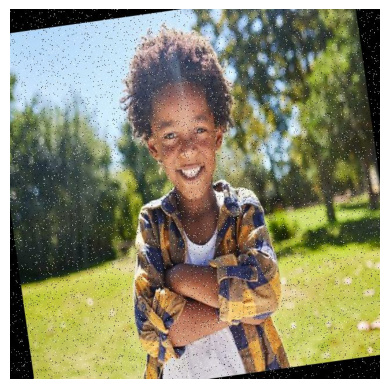

In [85]:
plt.imshow(train_images.as_numpy_iterator().next())
plt.axis('off')
plt.show()

In [86]:
# Show the type of the `images` object
print(type(train_images))

<class 'tensorflow.python.data.ops.map_op._MapDataset'>


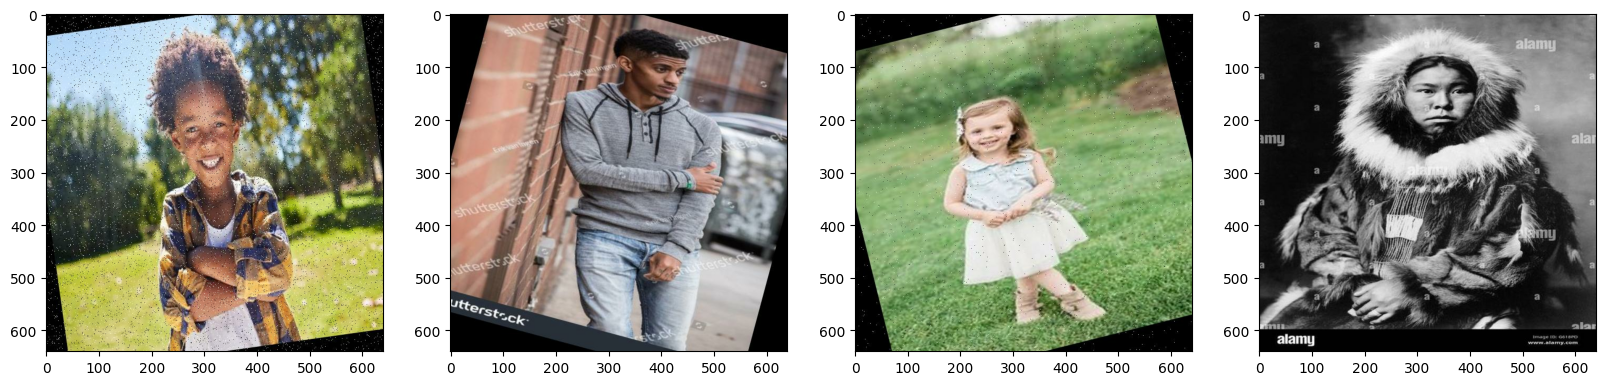

In [87]:
# Show more images
image_generator = train_images.batch(4).as_numpy_iterator()  # 4 images from train_images
plot_images = image_generator.next()  # get next batch of 4 images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))  #to plot the pictures
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()  #show images

## Loas Labels

In [89]:
import tensorflow as tf


# Get all filenames that have exactly one bounding box for each dataset split
train_single_bbox_files = get_single_bbox_files('350_faces-1/train/labels')
val_single_bbox_files = get_single_bbox_files('350_faces-1/valid/labels')
test_single_bbox_files = get_single_bbox_files('350_faces-1/test/labels')


train_labels_paths = tf.data.Dataset.from_tensor_slices(
    ['350_faces-1/train/labels/' + name + '.txt' for name in train_single_bbox_files]
)
val_labels_paths = tf.data.Dataset.from_tensor_slices(
    ['350_faces-1/valid/labels/' + name + '.txt' for name in val_single_bbox_files]
)
test_labels_paths = tf.data.Dataset.from_tensor_slices(
    ['350_faces-1/test/labels/' + name + '.txt' for name in test_single_bbox_files]
)

# Use tf.py_function to invoke load_labels for each dataset
train_labels = train_labels_paths.map(
    lambda x: tf.py_function(load_labels, [x], Tout=(tf.int32, tf.float32)),
    num_parallel_calls=tf.data.AUTOTUNE
)

val_labels = val_labels_paths.map(
    lambda x: tf.py_function(load_labels, [x], Tout=(tf.int32, tf.float32)),
    num_parallel_calls=tf.data.AUTOTUNE
)

test_labels = test_labels_paths.map(
    lambda x: tf.py_function(load_labels, [x], Tout=(tf.int32, tf.float32)),
    num_parallel_calls=tf.data.AUTOTUNE
)


In [90]:
import tensorflow as tf

# Convert into the right tensorflow label format (before the label fomat was from yolo)
def convert_coords_tf(coords):
    x_center, y_center, width, height = coords[0], coords[1], coords[2], coords[3]
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2


    return tf.convert_to_tensor([x_min, y_min, x_max, y_max], dtype=tf.float32)


@tf.function
def transform_labels(label, coords):
    new_coords = tf.map_fn(convert_coords_tf, coords, dtype=tf.float32, fn_output_signature=tf.TensorSpec(shape=(4,), dtype=tf.float32))

    return label, new_coords


# Applying the transformation function to the entire dataset
train_labels_transformed = train_labels.map(transform_labels)
test_labels_transformed = test_labels.map(transform_labels)
val_labels_transformed = val_labels.map(transform_labels)



In [91]:
def squeeze_labels(label_class, label_coords):
    # Removing the superfluous dimensions
    label_coords_squeezed = tf.squeeze(label_coords, axis=0)

    return label_class, label_coords_squeezed

# Apply the function to the entire data set
train_labels_transformed = train_labels_transformed.map(squeeze_labels)
test_labels_transformed = test_labels_transformed.map(squeeze_labels)
val_labels_transformed = val_labels_transformed.map(squeeze_labels)

In [92]:
print(train_labels_transformed.as_numpy_iterator().next())

(array([0], dtype=int32), array([0.353125  , 0.17890625, 0.575     , 0.53203124], dtype=float32))


In [93]:
print(type(train_labels_transformed))

<class 'tensorflow.python.data.ops.map_op._MapDataset'>


In [94]:
print(type(train_images))
print(type(test_images))

<class 'tensorflow.python.data.ops.map_op._MapDataset'>
<class 'tensorflow.python.data.ops.map_op._MapDataset'>


In [96]:
train_images.as_numpy_iterator().next()

array([[[ 0,  0,  0],
        [ 2,  2,  2],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 3,  3,  3],
        [14, 14, 14],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [17, 17, 17],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [12, 12, 12],
        [ 0,  0,  0],
        [16, 16, 16]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 3,  3,  3],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

In [97]:
test_images.as_numpy_iterator().next()

array([[[249, 248, 244],
        [249, 248, 244],
        [249, 248, 244],
        ...,
        [241, 232, 225],
        [241, 232, 225],
        [241, 232, 225]],

       [[249, 248, 244],
        [249, 248, 244],
        [249, 248, 244],
        ...,
        [240, 231, 224],
        [240, 231, 224],
        [240, 231, 224]],

       [[249, 248, 244],
        [249, 248, 244],
        [249, 248, 244],
        ...,
        [239, 230, 223],
        [239, 230, 223],
        [239, 230, 223]],

       ...,

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1]]

In [98]:
val_images.as_numpy_iterator().next()

array([[[248, 248, 248],
        [248, 248, 248],
        [248, 248, 248],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       [[248, 248, 248],
        [248, 248, 248],
        [248, 248, 248],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       [[248, 248, 248],
        [248, 248, 248],
        [248, 248, 248],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       ...,

       [[  1,   1,   1],
        [121, 121, 121],
        [206, 206, 206],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  1,   1,   1],
        [121, 121, 121],
        [206, 206, 206],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  1,   1,   1],
        [121, 121, 121],
        [206, 206, 206],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

## Combining Label and Image Samples

In [99]:
len(train_images), len(train_labels_transformed), len(test_images), len(test_labels_transformed), len(val_images), len(val_labels_transformed)

(531, 531, 26, 26, 56, 56)

In [100]:
train = tf.data.Dataset.zip((train_images, train_labels_transformed))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [101]:
test = tf.data.Dataset.zip((test_images, test_labels_transformed))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)


In [102]:
val = tf.data.Dataset.zip((val_images, val_labels_transformed))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [108]:
data_samples = train.as_numpy_iterator()

In [109]:
res = data_samples.next()

In [110]:
print(res[1][1][3]) #Coord
print(res[1][1][2])
print(res[1][1][1])
print(res[1][1][0])

[0.49375004 0.08984375 0.721875   0.40546876]
[0.33515626 0.2796875  0.51484376 0.55625   ]
[0.27109376 0.20468749 0.43984374 0.4765625 ]
[0.48671874 0.06406249 0.7632812  0.33125   ]


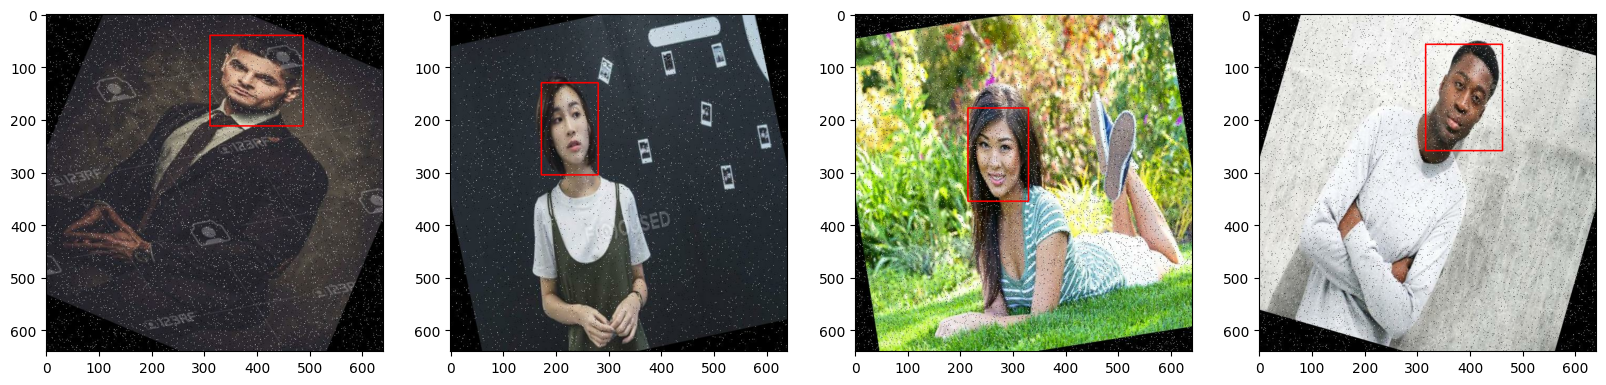

In [115]:
import cv2
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [640,640]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [640,640]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Build Deep Learning

In [116]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [117]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [118]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [119]:
def build_model():
    input_layer = Input(shape=(640,640,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=regress2)
    return facetracker

In [120]:
facetracker = build_model()

In [121]:
facetracker.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 640, 640, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 2048)              1050624   
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 15773508 (60.17 MB)
Trainable params: 15773508 (60.17 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [122]:
X, y = train.as_numpy_iterator().next()

In [123]:
X.shape

(8, 640, 640, 3)

In [124]:
y

(array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=int32),
 array([[0.20273437, 0.09257813, 0.38789064, 0.2824219 ],
        [0.62109375, 0.36875   , 0.7023437 , 0.490625  ],
        [0.43593752, 0.11874999, 0.678125  , 0.3390625 ],
        [0.5460937 , 0.14765626, 0.69921875, 0.30078125],
        [0.540625  , 0.1375    , 0.7015625 , 0.2921875 ],
        [0.38828126, 0.11562499, 0.5601562 , 0.34375   ],
        [0.10976562, 0.14179686, 0.61679685, 0.58632815],
        [0.5210937 , 0.15078124, 0.6273438 , 0.29453126]], dtype=float32))

In [125]:
coords = facetracker.predict(X)
coords  #just for testing

1/1 [==============================] - 10s 10s/step


array([[1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 2.7204851e-12],
       [1.0000000e+00, 1.0000000e+00, 2.5600281e-01, 1.1304662e-13],
       [3.1130010e-04, 1.0000000e+00, 4.1407159e-07, 9.3531086e-14],
       [2.9333517e-29, 1.0000000e+00, 2.3309322e-14, 2.7221705e-17],
       [2.8543525e-08, 1.0000000e+00, 4.9769636e-08, 5.8446804e-18],
       [1.9765251e-13, 1.0000000e+00, 1.1314971e-03, 9.9997485e-01],
       [2.4920858e-08, 1.0000000e+00, 9.9659449e-01, 2.2686518e-06],
       [1.6915404e-13, 1.0000000e+00, 7.4689275e-01, 6.0297079e-17]],
      dtype=float32)

## Define Losses and Optimizers

In [127]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [128]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [129]:
# distance between our actual coord and our predicted coords
def localization_loss(y_true, yhat):
    print(y_true)
    print(y_true[:,:2])
    print(yhat)
    print(yhat[:,:2])
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [130]:
regressloss = localization_loss

In [131]:
y[1]

array([[0.20273437, 0.09257813, 0.38789064, 0.2824219 ],
       [0.62109375, 0.36875   , 0.7023437 , 0.490625  ],
       [0.43593752, 0.11874999, 0.678125  , 0.3390625 ],
       [0.5460937 , 0.14765626, 0.69921875, 0.30078125],
       [0.540625  , 0.1375    , 0.7015625 , 0.2921875 ],
       [0.38828126, 0.11562499, 0.5601562 , 0.34375   ],
       [0.10976562, 0.14179686, 0.61679685, 0.58632815],
       [0.5210937 , 0.15078124, 0.6273438 , 0.29453126]], dtype=float32)

In [132]:
y[1].shape

(8, 4)

In [133]:
coords.shape

(8, 4)

In [134]:
y[1]

array([[0.20273437, 0.09257813, 0.38789064, 0.2824219 ],
       [0.62109375, 0.36875   , 0.7023437 , 0.490625  ],
       [0.43593752, 0.11874999, 0.678125  , 0.3390625 ],
       [0.5460937 , 0.14765626, 0.69921875, 0.30078125],
       [0.540625  , 0.1375    , 0.7015625 , 0.2921875 ],
       [0.38828126, 0.11562499, 0.5601562 , 0.34375   ],
       [0.10976562, 0.14179686, 0.61679685, 0.58632815],
       [0.5210937 , 0.15078124, 0.6273438 , 0.29453126]], dtype=float32)

In [135]:
coords

array([[1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 2.7204851e-12],
       [1.0000000e+00, 1.0000000e+00, 2.5600281e-01, 1.1304662e-13],
       [3.1130010e-04, 1.0000000e+00, 4.1407159e-07, 9.3531086e-14],
       [2.9333517e-29, 1.0000000e+00, 2.3309322e-14, 2.7221705e-17],
       [2.8543525e-08, 1.0000000e+00, 4.9769636e-08, 5.8446804e-18],
       [1.9765251e-13, 1.0000000e+00, 1.1314971e-03, 9.9997485e-01],
       [2.4920858e-08, 1.0000000e+00, 9.9659449e-01, 2.2686518e-06],
       [1.6915404e-13, 1.0000000e+00, 7.4689275e-01, 6.0297079e-17]],
      dtype=float32)

In [136]:
localization_loss(y[1], coords) #Test

[[0.20273437 0.09257813 0.38789064 0.2824219 ]
 [0.62109375 0.36875    0.7023437  0.490625  ]
 [0.43593752 0.11874999 0.678125   0.3390625 ]
 [0.5460937  0.14765626 0.69921875 0.30078125]
 [0.540625   0.1375     0.7015625  0.2921875 ]
 [0.38828126 0.11562499 0.5601562  0.34375   ]
 [0.10976562 0.14179686 0.61679685 0.58632815]
 [0.5210937  0.15078124 0.6273438  0.29453126]]
[[0.20273437 0.09257813]
 [0.62109375 0.36875   ]
 [0.43593752 0.11874999]
 [0.5460937  0.14765626]
 [0.540625   0.1375    ]
 [0.38828126 0.11562499]
 [0.10976562 0.14179686]
 [0.5210937  0.15078124]]
[[1.0000000e+00 1.0000000e+00 1.0000000e+00 2.7204851e-12]
 [1.0000000e+00 1.0000000e+00 2.5600281e-01 1.1304662e-13]
 [3.1130010e-04 1.0000000e+00 4.1407159e-07 9.3531086e-14]
 [2.9333517e-29 1.0000000e+00 2.3309322e-14 2.7221705e-17]
 [2.8543525e-08 1.0000000e+00 4.9769636e-08 5.8446804e-18]
 [1.9765251e-13 1.0000000e+00 1.1314971e-03 9.9997485e-01]
 [2.4920858e-08 1.0000000e+00 9.9659449e-01 2.2686518e-06]
 [1.69154

<tf.Tensor: shape=(), dtype=float32, numpy=19.478603>

## Train Neural Network

In [137]:
class FaceTracker(Model):
    def __init__(self, facetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            coords = self.model(X, training=True)

            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        coords = self.model(X, training=False)

        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss

        return {"total_loss":total_loss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [138]:
model = FaceTracker(facetracker)

In [139]:
model.compile(opt, regressloss)

## Train

In [140]:
logdir='logs'

In [141]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [142]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, None), dtype=tf.uint8, name=None), (TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

In [143]:
hist = model.fit(train, epochs=100, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/100
Tensor("IteratorGetNext:2", shape=(None, 4), dtype=float32)
Tensor("strided_slice:0", shape=(None, 2), dtype=float32)
Tensor("model/dense_1/Sigmoid:0", shape=(None, 4), dtype=float32)
Tensor("strided_slice_1:0", shape=(None, 2), dtype=float32)
Tensor("IteratorGetNext:2", shape=(None, 4), dtype=float32)
Tensor("strided_slice:0", shape=(None, 2), dtype=float32)
Tensor("model/dense_1/Sigmoid:0", shape=(None, 4), dtype=float32)
Tensor("strided_slice_1:0", shape=(None, 2), dtype=float32)
67/67 [==============================] - ETA: 0s - total_loss: 8.6682Tensor("IteratorGetNext:2", shape=(None, 4), dtype=float32)
Tensor("strided_slice:0", shape=(None, 2), dtype=float32)
Tensor("model/dense_1/Sigmoid:0", shape=(None, 4), dtype=float32)
Tensor("strided_slice_1:0", shape=(None, 2), dtype=float32)
67/67 [==============================] - 28s 329ms/step - total_loss: 8.5841 - val_total_loss: 8.1021
Epoch 2/100
67/67 [==============================] - 20s 286ms/step - total_loss: 8.4

## Plot Performance

In [144]:
hist.history

{'total_loss': [2.948253631591797,
  3.0025453567504883,
  4.002667427062988,
  2.791127920150757,
  2.723785400390625,
  2.5461525917053223,
  3.2142693996429443,
  4.594647407531738,
  2.9182465076446533,
  3.0939948558807373,
  3.032877206802368,
  2.9802849292755127,
  2.6890711784362793,
  4.349719047546387,
  3.073702812194824,
  3.3896172046661377,
  3.516502857208252,
  3.237199068069458,
  3.49229097366333,
  4.45998477935791,
  3.228876829147339,
  3.329249382019043,
  3.7913224697113037,
  3.2583303451538086,
  3.497227907180786,
  3.116215229034424,
  2.835855007171631,
  3.220153331756592,
  3.0020570755004883,
  3.6112565994262695,
  4.12471866607666,
  3.09765625,
  3.4943830966949463,
  3.056596040725708,
  3.112401008605957,
  3.333066701889038,
  2.5802576541900635,
  3.845047950744629,
  2.8353495597839355,
  2.5576791763305664,
  2.867523193359375,
  2.909353733062744,
  4.441463470458984,
  3.9401659965515137,
  2.8502206802368164,
  2.8568081855773926,
  3.0924062

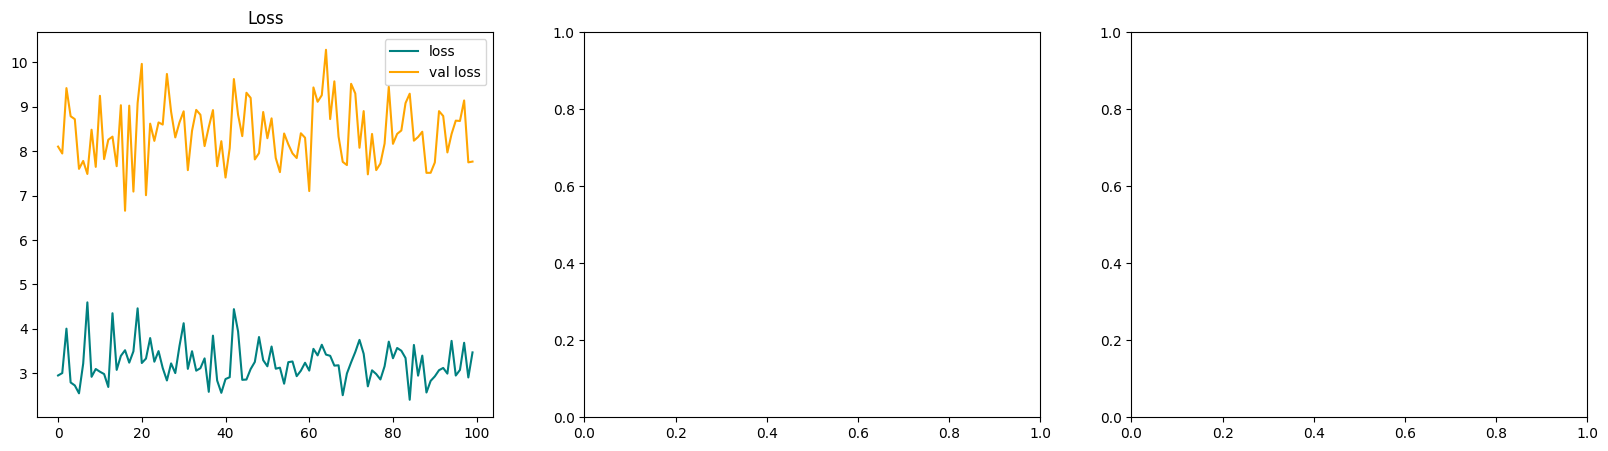

In [145]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

plt.show()

## Make Predictions

In [146]:
test_data = test.as_numpy_iterator()

In [155]:
test_sample = test_data.next()

In [156]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 26ms/step


In [159]:
yhat

array([[0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 0., 1.]], dtype=float32)

Unfortunately, we can see that the model really doesn't work at all, It doesn't improve during training and the Predictions are meaningless ...